##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 2 - Classifying embeddings with Keras and the Gemini API

## Overview

Welcome back to the Kaggle 5-day Generative AI course. In this notebook, you'll learn to use the embeddings produced by the Gemini API to train a model that can classify newsgroup posts into the categories (the newsgroup itself) from the post contents.

This technique uses the Gemini API's embeddings as input, avoiding the need to train on text input directly, and as a result it is able to perform quite well using relatively few examples compared to training a text model from scratch.

## ADDITIONAL HYPERPARAMETER TUNING! BONUS ON BONUS.
I didn't know there was such an interesting application of deepNN and semantic embeddings, so I tuned the model all the way at the bottom using a Keras random search tuner. Shout out to Dr. Toriko of DePaul U. from Deep NN class last year. (used an accelator to run this)

**Results summary**:
When working with high-quality embeddings like those from Gemini, simple neural architectures often perform surprisingly well because the embeddings already encode rich semantic information. The optimal model's use of just 192 units rather than the full 768-dimensional embedding creates an information bottleneck that forces the network to extract only the most relevant features for classification, eliminating the need for regularization techniques like dropout or batch normalization.

In [2]:
!pip uninstall -qqy jupyterlab kfp 2>/dev/null  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

In [3]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will use sampled subsets of the training and test sets, and perform some processing using Pandas.

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is an example of what a record from the training set looks like.

In [6]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Start by preprocessing the data for this tutorial in a Pandas dataframe. To remove any sensitive information like names and email addresses, you will take only the subject and body of each message. This is an optional step that transforms the input data into more generic text, rather than email posts, so that it will work in other contexts.

In [7]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate each entry to 5,000 characters
    text = text[:5000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [8]:
# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [9]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]

    # We have fewer categories now, so re-calibrate the label encoding.
    df["Class Name"] = df["Class Name"].astype("category")
    df["Encoded Label"] = df["Class Name"].cat.codes

    return df

In [10]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
# Class name should contain 'sci' to keep science categories.
# Try different labels from the data - see newsgroups_train.target_names
CLASSES_TO_KEEP = "sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [11]:
df_train.value_counts("Class Name")

Class Name
sci.crypt          100
sci.electronics    100
sci.med            100
sci.space          100
Name: count, dtype: int64

In [12]:
df_test.value_counts("Class Name")

Class Name
sci.crypt          25
sci.electronics    25
sci.med            25
sci.space          25
Name: count, dtype: int64

## Create the embeddings

In this section, you will generate embeddings for each piece of text using the Gemini API embeddings endpoint. To learn more about embeddings, visit the [embeddings guide](https://ai.google.dev/docs/embeddings_guide).

**NOTE**: Embeddings are computed one at a time, so large sample sizes can take a long time!

### Task types

The `text-embedding-004` model supports a task type parameter that generates embeddings tailored for the specific task.

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.
FACT_VERIFICATION | Specifies that the given text will be used for fact verification.

For this example you will be performing classification.

In [13]:
from google.api_core import retry
import tqdm
from tqdm.rich import tqdm as tqdmr
import warnings

# Add tqdm to Pandas...
tqdmr.pandas()

# ...But suppress the experimental warning.
warnings.filterwarnings("ignore", category=tqdm.TqdmExperimentalWarning)

# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

@retry.Retry(predicate=is_retriable, timeout=300.0)
def embed_fn(text: str) -> list[float]:
    # You will be performing classification, so set task_type accordingly.
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=text,
        config=types.EmbedContentConfig(
            task_type="classification",
        ),
    )

    return response.embeddings[0].values


def create_embeddings(df):
    df["Embeddings"] = df["Text"].progress_apply(embed_fn)
    return df

This code is optimised for clarity, and is not particularly fast. It is left as an exercise for the reader to implement [batch](https://ai.google.dev/api/embeddings#method:-models.batchembedcontents) or parallel/asynchronous embedding generation. Running this step will take some time.

In [14]:
df_train = create_embeddings(df_train)
df_test = create_embeddings(df_test)

Output()

Output()

In [15]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,RIPEM Frequently Asked Questions\n\nArchive-na...,11,sci.crypt,0,"[-0.003882501, 0.023245921, -0.034277435, 0.00..."
1101,"Re: Pgp, PEM, and RFC's (Was: Cryptography Pat...",11,sci.crypt,0,"[-0.011718064, 0.02755031, -0.029747022, -0.01..."
1102,Cryptography FAQ 09/10 - Other Miscellany\n\nA...,11,sci.crypt,0,"[0.013660435, 0.01853579, -0.051745623, 0.0133..."
1103,"Re: Once tapped, your code is no good any more...",11,sci.crypt,0,"[0.005239672, 0.018618511, -0.0505974, 0.02780..."
1104,"Re: Pgp, PEM, and RFC's (Was: Cryptography Pat...",11,sci.crypt,0,"[-0.009729882, 0.03217629, -0.035181765, 0.012..."


## Build a classification model

Here you will define a simple model that accepts the raw embedding data as input, has one hidden layer, and an output layer specifying the class probabilities. The prediction will correspond to the probability of a piece of text being a particular class of news.

When you run the model, Keras will take care of details like shuffling the data points, calculating metrics and other ML boilerplate.

In [16]:
import keras
from keras import layers


def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
    return keras.Sequential(
        [
            layers.Input([input_size], name="embedding_inputs"),
            layers.Dense(input_size, activation="relu", name="hidden"),
            layers.Dense(num_classes, activation="softmax", name="output_probs"),
        ]
    )

In [17]:
# Derive the embedding size from observing the data. The embedding size can also be specified
# with the `output_dimensionality` parameter to `embed_content` if you need to reduce it.
embedding_size = len(df_train["Embeddings"].iloc[0])

classifier = build_classification_model(
    embedding_size, len(df_train["Class Name"].unique())
)
classifier.summary()

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probs (Dense)            │ (None, 4)              │         3,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,668 (2.26 MB)

 Trainable params: 593,668 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Finally, you can train your model. This code uses early stopping to exit the training loop once the loss value stabilises, so the number of epoch loops executed may differ from the specified value.

In [18]:
import numpy as np


NUM_EPOCHS = 20
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train["Encoded Label"]
x_train = np.stack(df_train["Embeddings"])
y_val = df_test["Encoded Label"]
x_val = np.stack(df_test["Embeddings"])

# Specify that it's OK to stop early if accuracy stabilises.
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

# Train the model for the desired number of epochs.
history = classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

Epoch 1/20


I0000 00:00:1743560978.622497      81 service.cc:145] XLA service 0x7c6aa400e3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743560978.622546      81 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1743560978.622550      81 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2500 - loss: 1.3881

I0000 00:00:1743560979.773185      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.4001 - loss: 1.3550 - val_accuracy: 0.5800 - val_loss: 1.2555
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6403 - loss: 1.1891 - val_accuracy: 0.6600 - val_loss: 1.1501
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7455 - loss: 1.0364 - val_accuracy: 0.6300 - val_loss: 1.0204
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8665 - loss: 0.8368 - val_accuracy: 0.7100 - val_loss: 0.8972
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8785 - loss: 0.7008 - val_accuracy: 0.8400 - val_loss: 0.7462
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9409 - loss: 0.5343 - val_accuracy: 0.8700 - val_loss: 0.6304
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9382 - loss: 0.4388 - val_accuracy: 0.9000 - val_loss: 0.5285
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9745 - loss: 0.3081 - val_accuracy: 0.9200 - val_loss: 0.4693
Ep

## Evaluate model performance

Use Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate"><code>Model.evaluate</code></a> to calculate the loss and accuracy on the test dataset.

In [19]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9069 - loss: 0.3237 


{'accuracy': 0.8999999761581421, 'loss': 0.32021915912628174}

To learn more about training models with Keras, including how to visualise the model training metrics, read [Training & evaluation with built-in methods](https://www.tensorflow.org/guide/keras/training_with_built_in_methods).

## Try a custom prediction

Now that you have a trained model with good evaluation metrics, you can try to make a prediction with new, hand-written data. Use the provided example or try your own data to see how the model performs.

In [20]:
def make_prediction(text: str) -> list[float]:
    """Infer categories from the provided text."""
    #model takes embeddings as input, so calculate them first.
    embedded = embed_fn(new_text)

    #input must be batched, so here they are wrapped as a list to provide a batch of 1.
    inp = np.array([embedded])

    # And un-batched here.
    [result] = classifier.predict(inp)
    return result

In [21]:
# This example avoids any space-specific terminology to see if the model avoids
# biases towards specific jargon.
new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

result = make_prediction(new_text)

for idx, category in enumerate(df_test["Class Name"].cat.categories):
    print(f"{category}: {result[idx] * 100:0.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
sci.crypt: 0.07%
sci.electronics: 0.06%
sci.med: 0.03%
sci.space: 99.84%


## Further reading

To explore training custom models with Keras further, check out the [Keras guides](https://keras.io/guides/).

*- [Mark McD](https://linktr.ee/markmcd)*

## Hyperparameter tuning!

#### Not that we needed to tune it given the 92 pct accuracy. I just wanted to make sure its nice and super **overfit**! 

In [22]:
!pip install -q keras-tuner

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [23]:
# Import Keras Tuner and visualization libraries
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns

## Hyperparameter Tuning with Keras Tuner

In this section, we implement automated hyperparameter optimization to find the ideal neural network architecture for our embedding-based newsgroup classifier. Rather than manually testing different configurations, we'll use Keras Tuner's RandomSearch to systematically explore combinations of network depth, layer sizes, activation functions, dropout rates, and learning rates. This approach efficiently searches the hyperparameter space to find the optimal model configuration while saving time rather than doing it iteratively (no one likes finding params 1 layer and LR at a time). Then I added visualizations to understand how different hyperparameter choices affect model accuracy.

In [24]:
# Define the model builder with hyperparameters to search
def model_builder(hp):
    model = keras.Sequential()
    model.add(layers.Input([embedding_size], name="embedding_inputs"))
    
    # Tune number of layers
    num_layers = hp.Int('num_layers', 1, 4)
    print(f"Building model with {num_layers} layers...")
    
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        dropout_rate = hp.Float(f'dropout_{i}', 0, 0.5, step=0.1)
        use_bn = hp.Boolean(f'batch_norm_{i}')
        
        print(f"  Layer {i+1}: {units} units, {activation} activation, {dropout_rate} dropout, BN: {use_bn}")
        
        model.add(layers.Dense(units=units, activation=activation))
        model.add(layers.Dropout(dropout_rate))
        
        if use_bn:
            model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(len(df_train["Class Name"].unique()), activation='softmax'))
    
    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    print(f"Learning rate: {hp_learning_rate}")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

In [25]:
#Print progress
class PrintTrainingProgress(keras.callbacks.Callback):
    def __init__(self, trial_num):
        super().__init__()
        self.trial_num = trial_num
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Trial {self.trial_num}, Epoch {epoch+1}: val_accuracy = {logs['val_accuracy']:.4f}, val_loss = {logs['val_loss']:.4f}")

In [26]:
# Create a custom tuner class to show more info
class VerboseRandomSearch(RandomSearch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.current_trial = 0
        
    def on_trial_begin(self, trial):
        self.current_trial += 1
        print(f"\n--- Starting Trial {self.current_trial} ---")
        super().on_trial_begin(trial)
        
    def on_trial_end(self, trial):
        print(f"--- Trial {self.current_trial} completed ---")
        print(f"Score: {trial.score}")
        print("Hyperparameters:")
        for param, value in trial.hyperparameters.values.items():
            print(f"  {param}: {value}")
        print("\n")
        super().on_trial_end(trial)

In [27]:
# Set up the tuner
print("Initializing hyperparameter search...")
tuner = VerboseRandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,  # Increase for more thorough search
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='newsgroup_classification')

Initializing hyperparameter search...
Building model with 1 layers...
  Layer 1: 32 units, relu activation, 0.0 dropout, BN: False
Learning rate: 0.01


In [28]:
# Define callbacks for the search
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Start the search
print("\n===== STARTING HYPERPARAMETER SEARCH =====")
tuner.search(x_train, y_train, 
             epochs=20, 
             validation_data=(x_val, y_val),
             callbacks=[stop_early])
print("===== HYPERPARAMETER SEARCH COMPLETED =====\n")

Trial 10 Complete [00h 00m 18s]
val_accuracy: 0.9150000214576721

Best val_accuracy So Far: 0.9399999976158142
Total elapsed time: 00h 03m 01s
===== HYPERPARAMETER SEARCH COMPLETED =====



In [29]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


# Print the optimal hyperparameters in a nice format
print("\n===== OPTIMAL HYPERPARAMETERS =====")
print(f"Number of layers: {best_hps.get('num_layers')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print("Layer configuration:")
for i in range(best_hps.get('num_layers')):
    print(f"  Layer {i+1}:")
    print(f"    Units: {best_hps.get(f'units_{i}')}")
    print(f"    Activation: {best_hps.get(f'activation_{i}')}")
    print(f"    Dropout rate: {best_hps.get(f'dropout_{i}')}")
    print(f"    Batch normalization: {best_hps.get(f'batch_norm_{i}')}")
print("===================================\n")


===== OPTIMAL HYPERPARAMETERS =====
Number of layers: 1
Learning rate: 0.001
Layer configuration:
  Layer 1:
    Units: 256
    Activation: tanh
    Dropout rate: 0.0
    Batch normalization: True



And here I thought that this could be unnecessarily complicated... can't even call 1 layer NN a deep neural network :(

This is actually a good lesson in that when you're using high-quality embeddings, you maybe don't need a very complex neural network on top of them. They probably encode rich-enough semantic information about the text, so even a simple classifier can achieve good performance.

There is one thing that is really cool about this though! the one layer had only 192 units over 768. I have to dig this up in my old books, but I think this a classic bottleneck creation from information theory which makes the model learn more efficiently and generalize less (which is probably we didn't need dropout or batch norm). Neat...

In [30]:
# Build the model with the optimal hyperparameters
print("Training best model with optimal hyperparameters...")
best_model = tuner.hypermodel.build(best_hps)

# Retrain the model and save history for visualization
history = best_model.fit(
    x_train, 
    y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[stop_early],
    verbose=1
)

Training best model with optimal hyperparameters...
Building model with 1 layers...
  Layer 1: 256 units, tanh activation, 0.0 dropout, BN: True
Learning rate: 0.001
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6361 - loss: 0.8991 - val_accuracy: 0.7200 - val_loss: 1.2655
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - loss: 0.0830 - val_accuracy: 0.8200 - val_loss: 1.2042
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0494 - val_accuracy: 0.8000 - val_loss: 1.1757
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0223 - val_accuracy: 0.9300 - val_loss: 1.1482
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 0.9200 - val_loss: 1.1231
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0101 - val_accuracy: 0.9400 - val_loss: 1.1035
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 

In [31]:
# Evaluate the best model
print("\n===== MODEL EVALUATION =====")
eval_result = best_model.evaluate(x_val, y_val)
print(f"Best model validation loss: {eval_result[0]:.4f}")
print(f"Best model validation accuracy: {eval_result[1]:.4f}")

# Compare with original model performance
print("\nComparing with original model:")
original_eval = classifier.evaluate(x_val, y_val)
print(f"Original model validation loss: {original_eval[0]:.4f}")
print(f"Original model validation accuracy: {original_eval[1]:.4f}")

improvement = (eval_result[1] - original_eval[1]) * 100
print(f"Accuracy improvement: {improvement:.2f}%")
print("===========================\n")


===== MODEL EVALUATION =====
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9140 - loss: 0.7046 
Best model validation loss: 0.6971
Best model validation accuracy: 0.9100

Comparing with original model:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9069 - loss: 0.3237 
Original model validation loss: 0.3202
Original model validation accuracy: 0.9000
Accuracy improvement: 1.00%



Bit of visualization of best parameters tuned

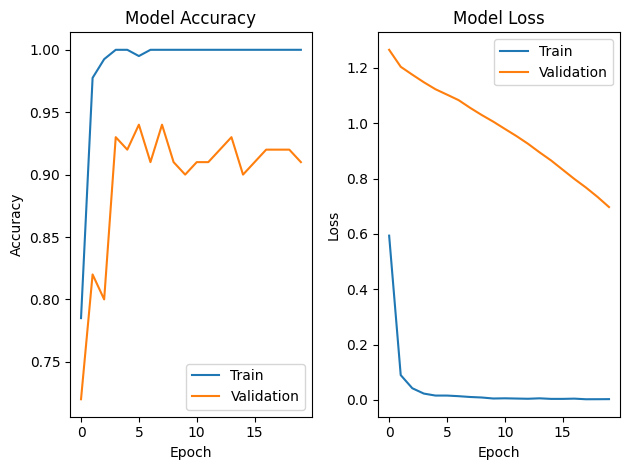

In [32]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

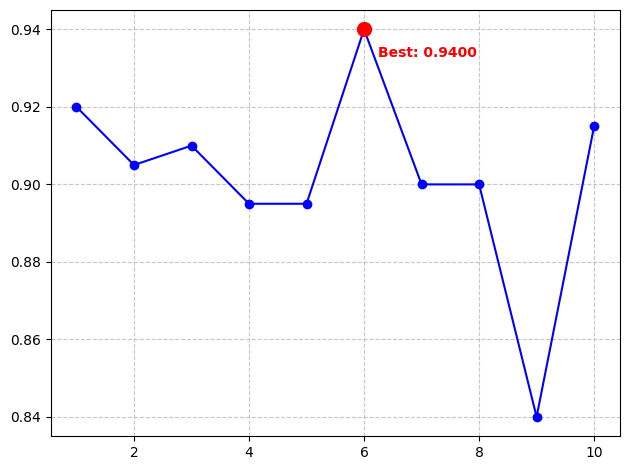

In [33]:
# Extract trial results
trials = tuner.oracle.trials
trial_ids = list(trials.keys())
accuracies = [t.score for t in trials.values() if t.score is not None]
x_values = list(range(1, len(accuracies) + 1))

# Plot the search progression
plt.plot(x_values, accuracies, 'o-', color='blue')
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the best trial
best_trial_idx = accuracies.index(max(accuracies))
plt.scatter([x_values[best_trial_idx]], [accuracies[best_trial_idx]], color='red', s=100, zorder=5)
plt.annotate(f"Best: {accuracies[best_trial_idx]:.4f}", 
             (x_values[best_trial_idx], accuracies[best_trial_idx]),
             xytext=(10, -20),
             textcoords='offset points',
             color='red',
             fontweight='bold')

plt.tight_layout()
plt.show()